# Graphical Causal Models for Causal Inference Analysis in Retail

This portion of the project aims at using Graphical Causal Models to answer different causal queries regarding the impact of late deliveries on customer ratings

In [137]:
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore
from scipy import stats

import matplotlib.pyplot as plt # type: ignore
plt.style.use('ggplot')
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore
from dowhy.gcm import AdditiveNoiseModel
from dowhy.gcm.shapley import ShapleyConfig, ShapleyApproximationMethods # type: ignore

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [138]:
df = pd.read_csv("../data/processed/data.csv")

In [139]:
# Impute missing values
df.rename(columns={'Product_price': 'revenue'}, inplace=True) 
df['Product_price'] = df['revenue'] + df['freight_value']
df['Product_weight_kg'] = df['Product_weight_kg'].fillna(df['Product_weight_kg'].mean())
df['distance_km'] = df['distance_km'].fillna(df['distance_km'].mean())
df['Product_size'] = df['Product_size'].fillna(df['Product_size'].mean())
# df['customer_avg_score'] = df['customer_avg_score'].fillna(df['customer_avg_score'].mean())
df['No_photos'] = df['No_photos'].fillna(df['No_photos'].mean())
df['Product_price'] = df['Product_price'].fillna(df['Product_price'].mean())
df['freight_value'] = df['freight_value'].fillna(df['freight_value'].mean())
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['Rating'] = df['Rating'].round()
df['Product_category'] = df['Product_category'].fillna(df['Product_category'].mode()[0])
df['revenue'] = df['revenue'].fillna(df['revenue'].mean())

In [129]:
df.shape

**Directed Acyclic Graph**

In [110]:
mapping_dict = {'Rating': 'discrete',
                'Product_category_encoded': 'categorical',
                'freight_value': 'continuous',
                'distance_km': 'continuous' ,
                'season': 'categorical' ,
                'is_delivery_late': 'categorical'}
# nodes
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'is_delivery_late'
]

# edges
edges_list = [
    ('season', 'Rating'),
    ('season', 'is_delivery_late'),
    ('season', 'Product_category_encoded'),
    ('is_delivery_late', 'Rating'),
    ('Product_category_encoded', 'is_delivery_late'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'freight_value'),
    ('Product_category_encoded', 'Rating'),
    ('freight_value', 'is_delivery_late'),
    ('freight_value', 'Rating'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'Rating'),
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

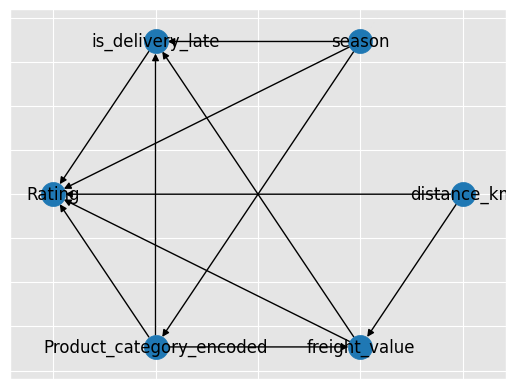

In [111]:
pos = nx.shell_layout(G)
nx.draw_networkx(G, pos, arrows=True)  
plt.show()

## Graphical Causal Models

- DoWhy-GCM implements a general purpose framework for modeling graphical causal models, which is based on the formal framework developed by Judea Pearl.

- Cause and effect relationships are represented via directed edges and the data generation process of each node in the graph given its parents is described by a so-called causal mechanism. These mechanisms are assumed to be modular, i.e., we can independently change the causal mechanism of one variable without affecting the causal mechanisms of other variables in the system

**1. Model cause-effect relationships in a graphical causal model**

The first step is to model the cause-effect relationships between variables through a causal graph (DAG). In addition, we assign a causal mechanism at each node in the causal graph that allows us to model the data generation process. *A causal mechanism of a node yields its conditional distribution given its parents* and modeling these mechanisms explicitly at each node allows us to answer a wide range of causal questions beyod typical effect estimation tasks.

example: *X -> Y, where we model the marginal distribution of Px and the conditional distribution of P(Y|X). Using an ANM here for Y, we obtain X := Nx and Y := f(X) + Ny where Nx and Ny are assumed to be independent. In DoWhy-GCM, noises Nx and Ny can be any probability distribution, whereas the function f can be any prediction function*


**2. Fit the causal mechanisms**

After assigning causal mechanisms to nodes in the causal graph, the next step is to learn the parameters of those mechanisms from data in case of parametric models. Note that DoWhy-GCM also allows users to provide their own "ground truth" causal mechanism. After this step, the GCM is ready for causal reasoning tasks. 


**3. Ask a causal question**

With a fitted GCM, users can then answer a wide range of causal questions, where the same fitted GCM can be reused for different queries.


**Structural Causal Model Assumptions**

- Modularity

In [112]:
# Defining Structural Causal Model from Graph
causal_model = gcm.StructuralCausalModel(G)

**Here we initialize instance of Structural Causal Model by providing DAG**

--

In [113]:
# Auto assigning causal mechanisms
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, df)
# print(auto_assignment_summary)

**In our DAG, the following causal mechanisms were automatically assigned**

- *distance_km is root node so assigning empirical distribution representing marginal distribution*

- *season is root node so assigning empirical distribution representing marginal distribution*

- *Product_category_encoded := f(season) + N*

- *freight value := f(Product category encoded,distance km) + N*

- *is_delivery_late := f(Product_category_encoded,freight_value,season) + N*

- *Rating := f(Product_category_encoded,distance_km,freight_value,is_delivery_late,season) + N*

--



In [114]:
# Fit generative models
gcm.fit(causal_model, df)

Fitting causal mechanism of node is_delivery_late: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]        


**After assigning the causal mechanisms, the next step is to learn the parameters of those mechanisms. In this case we used the auto assignment function DoWhy provides and below are the results**

- Causal Mechanism: **Product_category_encoded := f(season) + N** the following models were evaluated and picked the one with lowest **MSE**

    - LinearRegression: 487.7882492075425 *

    - Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression)]): 487.79290912700174
                
    - HistGradientBoostingRegressor: 488.0297010697885

--

- Causal Mechanism: **freight_value := f(Product_category_encoded,distance_km) + N** the following models were evaluated and picked the one with lowest **MSE**

    - HistGradientBoostingRegressor: 219.13238280236865 *

    - Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression)]): 220.54889120531303

    - LinearRegression: 220.80659117775068

--

- Causal Mechanism: **is_delivery_late := f(Product_category_encoded,freight_value,season) + N** the following models were evaluated and picked the one with lowest **MSE**

    - HistGradientBoostingRegressor: 0.05861736642288658 *

    - Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False))
    ('linearregression', LinearRegression)]): 0.059056155346672544
                    
    - LinearRegression: 0.05942966204689627

-- 

- Causal Mechanism: **Rating := f(Product_category_encoded,distance_km,freight_value,is_delivery_late,season) + N** the following models were evaluated and picked the one with lowest **MSE**

    - HistGradientBoostingRegressor: 1.7059305404002032 *

    - Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
    ('linearregression', LinearRegression)]): 1.710175027555812
    
    - LinearRegression: 1.7154086352840578


--



In [115]:
gcm.average_causal_effect(causal_model, 
                          'Rating',
                          interventions_alternative={'is_delivery_late': lambda x: 1},
                          interventions_reference={'is_delivery_late': lambda x:0},
                          num_samples_to_draw=10000)

In [116]:
gcm.average_causal_effect(causal_model, 
                          'Rating',
                          interventions_alternative={'is_delivery_late': lambda x: 1},
                          interventions_reference={'is_delivery_late': lambda x:0},
                          observed_data=df)

**Now that we understand how the data was generated, we can draw samples from it to calculate the average causal effect or we could use our observed sample in case there were potential interactions between root nodes that were not modeled**


Estimating the average causal effect is straightforward, seeing that this only requires comparing the two expectations of a target node based on samples from their respective interventional distribution.

The ACE estimation can be broken down into the following steps:

1. Draw samples from the interventional distribution of Y under treatment A
2. Draw samples from the interventional distribution of Y under treatment B
3. Compute their respective means
4. Take the differences of the means

$ACE = E[Y|do(T:=A)] - E[Y|do(T:=B)]$

---
---
#### Customizing Causal Mechanisms

**DoWhy allows us to manually the causal mechanisms based on our needs. This is where domain knowledge is great**

*Just a a remined, we assign different causal mechanisms based on the type of node*

**Root Nodes**
- **Empirical Distribution**: Random sampling from provided data

**Non-Root Nodes**

1. **Continuous Data - Additive Noise Models (ADM)**
   - $X_i = f(PA_i) + N_i$
   - Selection: Minimizing mean squared error

2. **Discrete Data - Discrete ADM**
   - Like continuous ADM, but f returns discrete values
   - Evaluation: Mean Squared Error (MSE)

3. **Categorical Data - Classifier-based Model**
   - $X_i = f(PA_i, N_i)$, where $N_i$ ~ U[0,1]
   - Selection: Optimizing F1 score


[Estimating Causal Effect Using GCM](https://www.pywhy.org/dowhy/v0.11.1/user_guide/causal_tasks/estimating_causal_effects/effect_estimation_with_gcm.html)

In [117]:
rng = np.random.default_rng()
causal_model = gcm.StructuralCausalModel(G)

for node in G.nodes:

    # grabbing node's parents if any
    parents = set(G.predecessors(node))

    # if node is a root
    if len(parents) == 0:
        random_mean = rng.normal()
        random_scale = abs(rng.normal())
        emp_dist = gcm.ScipyDistribution(stats.norm, loc=random_mean, scale=random_scale)
        causal_model.set_causal_mechanism(node=node, mechanism=emp_dist)

    else:
        node_type = mapping_dict[node]
        if node_type == 'discrete':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_regressor()))
        elif node_type == 'categorical':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_classifier())) 
        else:
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_linear_regressor())) 

gcm.fit(causal_model, df)


discrete||Rating
categorical||Product_category_encoded
continuous||freight_value
categorical||is_delivery_late


Fitting causal mechanism of node is_delivery_late: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]        


In [118]:
gcm.average_causal_effect(causal_model, 
                          'Rating',
                          interventions_alternative={'is_delivery_late': lambda x: 1},
                          interventions_reference={'is_delivery_late': lambda x:0},
                          num_samples_to_draw=10000)

We can observe how the ACE are different from the manually and auto assigned causal mechanisms. We could potentially fine tuned these prediction models to try to get even more accurate results

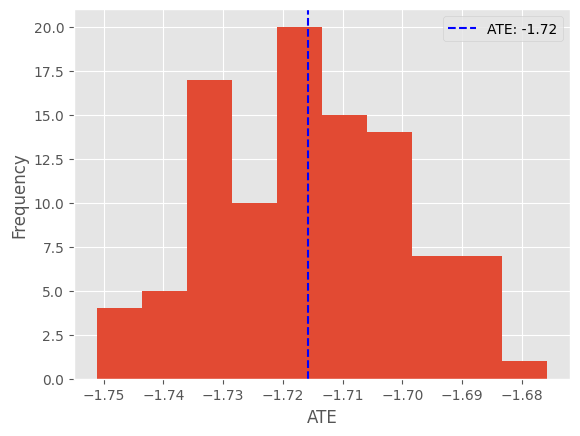

In [119]:
sample_mean_list = []
num_iter = 100

for i in range(num_iter):
    random_sample = gcm.draw_samples(causal_model=causal_model, num_samples=100000)
    treatment = random_sample[random_sample['is_delivery_late'] == 1]['Rating'].mean()
    control = random_sample[random_sample['is_delivery_late'] == 0]['Rating'].mean()
    ate = treatment - control
    sample_mean_list.append(ate)

plt.style.use('ggplot')
plt.hist(sample_mean_list)
plt.axvline(np.mean(sample_mean_list), linestyle='dashed', color='blue', label=f'ATE: {round(np.mean(sample_mean_list),2)}')
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---
---

### Other Causal Queries

Up to this point nothing is really new other than the method in which we arrive to the average causal effect. But using do-calculus and propensity scores, we were able to obtain a very similar result. This method, however, unlocks a serie of new causal queries that go beyond effect estimation. This is because we now know the data generating process. Some of these other techniques include:

- **Quantify Causal Influence**: These quantify causal influences, such as the strength of an edge or the intrinsic influence of nodes on a target.

    - **arrow_strength**: Quantifies the strength of an edge
    
    - **intrinsic_causal_influence**: Quantifies contribution fo a source node to the uncertainty in a target node

- **What-If**: These methods estimate the effect of interventions which can be more general beyond atomic interventions, and compute counterfactuals

    - **interventional_samples**: **Performs intervention on nodes in the causal graph**

    - **counterfactual_sampled**: **Estimates counterfactual data for observed data if we were to perform specified interventions**

- **Attribution**: These methods attribute observed effects (e.g., outliers, distributional changes) to their root causes (i.e., nodes upstream in the causal graph)

    - **attribute_anomalies**: Quantifies contributions to anomalies

    - **distribution_change**:  Quantifies the contribution of each node to the change in the distribution of the target

--


### Intrinsic Causal Influence

In [120]:
iccs_late_deliveries = gcm.intrinsic_causal_influence(causal_model=causal_model, 
                               target_node='Rating',
                               num_training_samples=10000,
                               num_samples_randomization=100,
                               shapley_config=ShapleyConfig(approximation_method=ShapleyApproximationMethods.PERMUTATION, num_permutations=100)
                               )

Evaluate set function: 62it [00:05, 11.49it/s]


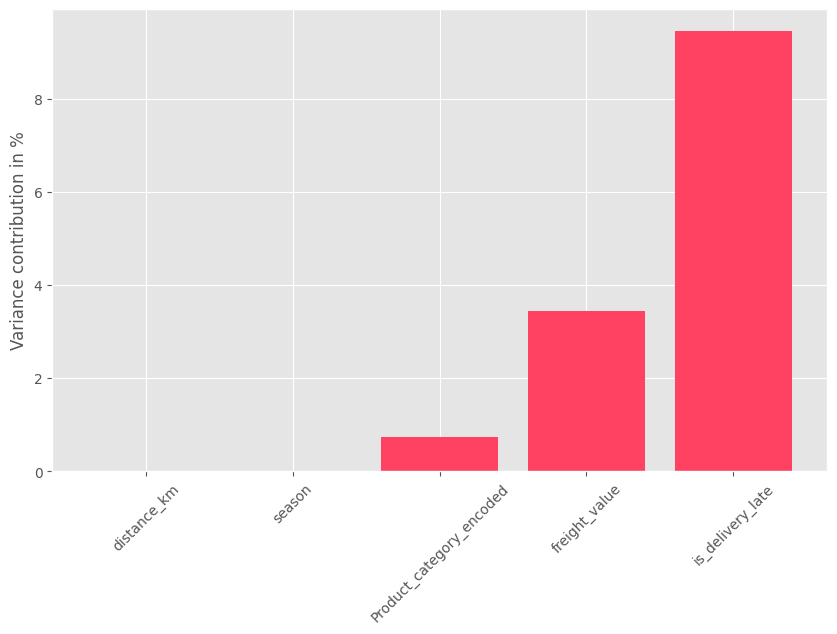

In [121]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

plt.figure(figsize=(10,6))
plt.bar(list(convert_to_percentage(iccs_late_deliveries).keys())[:-1], list(convert_to_percentage(iccs_late_deliveries).values())[:-1], color='#FF4162')
plt.ylabel("Variance contribution in %")
plt.xticks(rotation=45)
plt.show()

how to interpret the results?

-----

***Fine-tuning***

is_late_delivery = f(Product Category, Freight Value, Season) + N

In [16]:
def fine_tuned_random_forest_model(target, features, df):

    X = df[features]
    y = df[target]

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3)

    rf_model = RandomForestClassifier(class_weight='balanced')

    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [2, 4],
    }

    stratified_kfold = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(estimator=rf_model, 
                            param_grid=param_grid, 
                            scoring='f1', 
                            cv=stratified_kfold,  
                            n_jobs=-1,  
                            verbose=3)  

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Make predictions on the validation set
    y_val_pred = best_model.predict(X_val)

    print("F1: ", f1_score(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))

    return grid_search.best_estimator_


rf_model = fine_tuned_random_forest_model(target='is_delivery_late', features=['Product_category_encoded', 'freight_value', 'season'], df=df)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.238 total time=   1.4s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.242 total time=   1.4s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.242 total time=   1.6s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.246 total time=   2.8s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.246 total time=   1.3s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.248 total time=   3.0s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.247 total time=   3.0s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.240 total time=   1.6s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_sp

In [18]:
bet_params = rf_model.get_params()

In [19]:
rng = np.random.default_rng()
causal_model = gcm.StructuralCausalModel(G)

for node in G.nodes:

    # grabbing node's parents if any
    parents = set(G.predecessors(node))

    # if node is a root
    if len(parents) == 0:
        random_mean = rng.normal()
        random_scale = abs(rng.normal())
        emp_dist = gcm.ScipyDistribution(stats.norm, loc=random_mean, scale=random_scale)
        causal_model.set_causal_mechanism(node=node, mechanism=emp_dist)

    else:
        node_type = mapping_dict[node]
        if node_type == 'discrete':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_regressor()))

        elif node == 'is_delivery_late':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_random_forest_classifier(**bet_params))) 

        elif node_type == 'categorical' and node != 'is_delivery_late':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_classifier())) 

        else:
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_linear_regressor())) 


# Add debugging before fitting
print("Fitting the causal model")
print("DataFrame columns:", df.columns)
print("Graph nodes:", list(G.nodes))

gcm.fit(causal_model, df)

discrete||Rating
categorical||Product_category_encoded
continuous||freight_value
categorical||is_delivery_late
Fitting the causal model
DataFrame columns: Index(['order_id', 'payment_value', 'Rating', 'region', 'Product_weight_kg',
       'distance_km', 'Product_category', 'Product_size', 'No_photos',
       'revenue', 'season', 'is_delivery_late', 'Product_price.1',
       'freight_value', 'Product_category_encoded', 'late_delivery_in_days',
       'order_purchase_timestamp', 'Product_price'],
      dtype='object')
Graph nodes: ['Rating', 'Product_category_encoded', 'freight_value', 'distance_km', 'season', 'is_delivery_late']


Fitting causal mechanism of node is_delivery_late: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]        


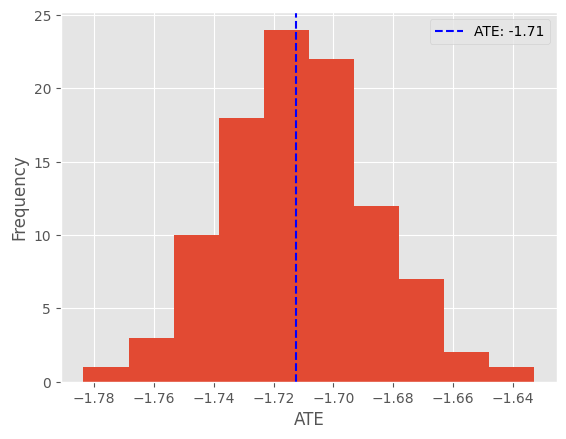

In [20]:
sample_mean_list = []
num_iter = 100

for i in range(num_iter):
    random_sample = gcm.draw_samples(causal_model=causal_model, num_samples=100000)
    treatment = random_sample[random_sample['is_delivery_late'] == 1]['Rating'].mean()
    control = random_sample[random_sample['is_delivery_late'] == 0]['Rating'].mean()
    ate = treatment - control
    sample_mean_list.append(ate)

plt.style.use('ggplot')
plt.hist(sample_mean_list)
plt.axvline(np.mean(sample_mean_list), linestyle='dashed', color='blue', label=f'ATE: {round(np.mean(sample_mean_list),2)}')
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---
**Resources**

https://arxiv.org/html/2206.06821v2